# Tutorial 5: Hierarchical Path Integration Network

> **Reading Time**: ~35-40 minutes
> **Difficulty**: Advanced
> **Prerequisites**: [Tutorials 1-4](./01_build_cann_model.ipynb)

This tutorial introduces hierarchical path integration networks, which combine multi-scale grid cells for robust spatial navigation in large environments.

---

## Table of Contents

1. [Introduction to Hierarchical Path Integration](#1-introduction-to-hierarchical-path-integration)
2. [Model Architecture](#2-model-architecture)
3. [Complete Example: Multi-Scale Navigation](#3-complete-example-multi-scale-navigation)
4. [Visualization and Analysis](#4-visualization-and-analysis)
5. [Next Steps](#5-next-steps)

---

## 1. Introduction to Hierarchical Path Integration

### 1.1 What is Hierarchical Path Integration?

Path integration is the ability to track position by integrating self-motion signals (velocity) over time. **Hierarchical path integration** uses multiple grid cell modules operating at different spatial scales to achieve:

- **Multi-scale representation**: Coarse scales for large spaces, fine scales for precision
- **Error correction**: Multiple scales provide redundancy against drift
- **Efficient coding**: Different modules tile space at different resolutions

### 1.2 Biological Inspiration

In the mammalian brain:
- **Grid cells** in medial entorhinal cortex fire at regular spatial intervals forming hexagonal patterns
- **Multiple modules** exist with different grid spacings (30cm to several meters)
- **Band cells** integrate velocity along preferred directions
- **Place cells** in hippocampus receive convergent input from grid cells

### 1.3 Key Components

The hierarchical network consists of:

1. **Band Cells** - Velocity integrators along specific orientations (0°, 60°, 120°)
2. **Grid Cells** - 2D continuous attractors forming hexagonal patterns
3. **Place Cells** - Readout layer combining information from all modules
4. **Multi-Module Architecture** - Multiple grid modules with different spacings

---

## 2. Model Architecture

### 2.1 Component Overview

In [1]:
from canns.models.basic import HierarchicalNetwork

# Create hierarchical network with 5 modules
hierarchical_net = HierarchicalNetwork(
    num_module=5,        # Number of grid modules (different scales)
    num_place=30,        # Place cells per dimension (30x30 = 900 total)
    spacing_min=2.0,     # Smallest grid spacing
    spacing_max=5.0,     # Largest grid spacing
    module_angle=0.0     # Base orientation angle
)

### 2.2 Key Parameters

| Parameter | Type | Description |
|-----------|------|-------------|
| `num_module` | int | Number of grid modules with different scales |
| `num_place` | int | Place cells per spatial dimension |
| `spacing_min` | float | Minimum grid spacing (finest scale) |
| `spacing_max` | float | Maximum grid spacing (coarsest scale) |
| `module_angle` | float | Base orientation for grid modules |

**Parameter Guidelines**:
- `num_module=5`: Good balance between coverage and computation
- `num_place=30`: Provides 900 place cells for 5x5m environment
- Spacing range should match environment size (larger spaces need larger `spacing_max`)

### 2.3 Internal Structure

Each module contains:
- **3 BandCell networks** at 0°, 60°, 120° orientations
- **1 GridCell network** combining band cell outputs
- Connections project to shared place cell population

---

## 3. Complete Example: Multi-Scale Navigation

### 3.1 Setup and Task Creation

In [1]:
import brainstate
import brainunit as u
import numpy as np
from canns.models.basic import HierarchicalNetwork
from canns.task.open_loop_navigation import OpenLoopNavigationTask

# Setup environment
brainstate.environ.set(dt=0.05)

# Create navigation task (5m x 5m environment)
task = OpenLoopNavigationTask(
    width=5.0,           # Environment width (meters)
    height=5.0,          # Environment height (meters)
    speed_mean=0.04,     # Mean speed (m/step)
    speed_std=0.016,     # Speed standard deviation
    duration=50000.0,    # Simulation duration (steps)
    dt=0.05,             # Time step
    start_pos=(2.5, 2.5), # Start at center
    progress_bar=True
)

# Generate trajectory data
task.get_data()

print(f"Trajectory: {task.data.position.shape[0]} steps")
print(f"Environment: {task.width}m x {task.height}m")

<OpenLoopNavigationTask>Generating Task data: 100%|██████████| 1000000/1000000 [00:00<00:00, 1565072.09it/s]


Trajectory: 1000000 steps
Environment: 5.0m x 5.0m


### 3.2 Create Hierarchical Network

In [2]:
# Create hierarchical network
hierarchical_net = HierarchicalNetwork(
    num_module=5,         # 5 different spatial scales
    num_place=30,         # 30x30 place cell grid
    spacing_min=2.0,      # Finest grid scale
    spacing_max=5.0,      # Coarsest grid scale
)

# Initialize state
hierarchical_net.init_state()

### 3.3 Initialization Phase

**Critical Step**: Initialize the network with strong location input to set initial position.

In [3]:
def initialize(t, input_strength):
    """Initialize network with location input"""
    hierarchical_net(
        velocity=u.math.zeros(2,),        # No velocity during init
        loc=task.data.position[0],        # Starting position
        loc_input_stre=input_strength,    # Input strength
    )

# Create initialization schedule
init_time = 500
indices = np.arange(init_time)
input_strength = np.zeros(init_time)
input_strength[:400] = 100.0  # Strong input for first 400 steps

# Run initialization
brainstate.transform.for_loop(
    initialize,
    u.math.asarray(indices),
    u.math.asarray(input_strength),
    pbar=brainstate.transform.ProgressBar(10),
)

print("Initialization complete")

  0%|          | 0/500 [00:00<?, ?it/s]

Initialization complete


**Why initialization matters**:
- Sets all grid modules to consistent starting state
- Strong location input (100.0) anchors the network
- Without proper init, modules may start desynchronized

### 3.4 Main Simulation Loop

In [4]:
def run_step(t, vel, loc):
    """Single simulation step with velocity input"""
    hierarchical_net(
        velocity=vel,           # Current velocity
        loc=loc,                # Current position (for reference)
        loc_input_stre=0.0      # No location input during navigation
    )

    # Extract firing rates from all layers
    band_x_r = hierarchical_net.band_x_fr.value   # X-direction band cells
    band_y_r = hierarchical_net.band_y_fr.value   # Y-direction band cells
    grid_r = hierarchical_net.grid_fr.value       # Grid cells
    place_r = hierarchical_net.place_fr.value     # Place cells

    return band_x_r, band_y_r, grid_r, place_r

# Get trajectory data
total_time = task.data.velocity.shape[0]
indices = np.arange(total_time)

# Run simulation
print("Running main simulation...")
band_x_r, band_y_r, grid_r, place_r = brainstate.transform.for_loop(
    run_step,
    u.math.asarray(indices),
    u.math.asarray(task.data.velocity),
    u.math.asarray(task.data.position),
    pbar=brainstate.transform.ProgressBar(10000),
)

print(f"Simulation complete!")
print(f"Band X cells: {band_x_r.shape}")
print(f"Band Y cells: {band_y_r.shape}")
print(f"Grid cells: {grid_r.shape}")
print(f"Place cells: {place_r.shape}")

Running main simulation...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Simulation complete!
Band X cells: (1000000, 5, 180)
Band Y cells: (1000000, 5, 180)
Grid cells: (1000000, 5, 400)
Place cells: (1000000, 900)


**Understanding the outputs**:
- `band_x_r`: Shape (T, num_module, num_cells) - Band cells for X components
- `band_y_r`: Shape (T, num_module, num_cells) - Band cells for Y components
- `grid_r`: Shape (T, num_module, num_gc_x, num_gc_y) - Grid cell activities
- `place_r`: Shape (T, num_place, num_place) - Place cell responses

---

## 4. Visualization and Analysis

### 4.1 Computing Firing Fields

Firing fields show where each neuron is active in the environment:

In [ ]:
from canns.analyzer.spatial import compute_firing_field, gaussian_smooth_heatmaps
from canns.analyzer.plotting import PlotConfig, plot_firing_field_heatmap

# Prepare data
loc = np.array(task.data.position)
width, height = 5.0, 5.0
M, K = 50, 50  # Spatial bins (50x50 grid)

T = grid_r.shape[0]

# Reshape arrays for firing field computation
grid_r = np.array(grid_r).reshape(T, -1)
band_x_r = np.array(band_x_r).reshape(T, -1)
band_y_r = np.array(band_y_r).reshape(T, -1)
place_r = np.array(place_r).reshape(T, -1)

# Compute firing fields
print("Computing firing fields...")
heatmaps_grid = compute_firing_field(grid_r, loc, width, height, M, K)
heatmaps_band_x = compute_firing_field(band_x_r, loc, width, height, M, K)
heatmaps_band_y = compute_firing_field(band_y_r, loc, width, height, M, K)
heatmaps_place = compute_firing_field(place_r, loc, width, height, M, K)

# Apply Gaussian smoothing
heatmaps_grid = gaussian_smooth_heatmaps(heatmaps_grid)
heatmaps_band_x = gaussian_smooth_heatmaps(heatmaps_band_x)
heatmaps_band_y = gaussian_smooth_heatmaps(heatmaps_band_y)
heatmaps_place = gaussian_smooth_heatmaps(heatmaps_place)

print(f"Firing fields computed: {heatmaps_grid.shape}")

Computing firing fields...
Firing fields computed: (2000, 50, 50)


### 4.2 Visualizing Grid Cell Patterns

Grid cells show characteristic hexagonal firing patterns:

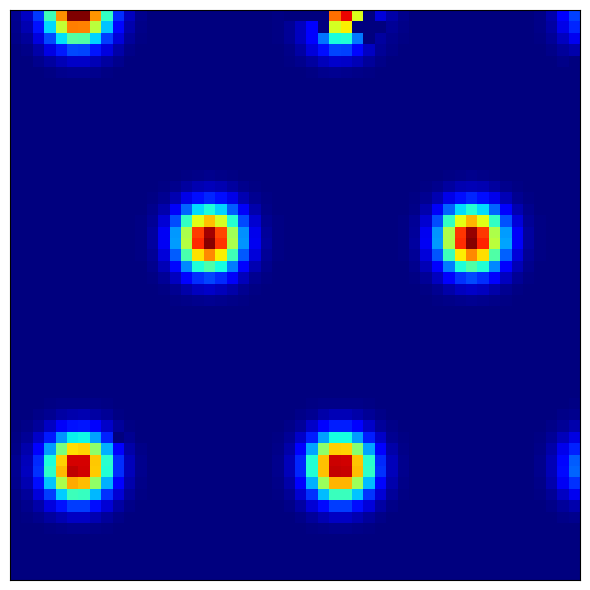

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [ ]:
# Reshape to separate modules
heatmaps_grid = heatmaps_grid.reshape(5, -1, M, K)  # (modules, cells, x, y)

# Visualize a grid cell from module 0
module_idx = 0
cell_idx = 10

config = PlotConfig(
    figsize=(6, 6),
    title=f'Grid Cell - Module {module_idx}, Cell {cell_idx}',
    xlabel='X Position (m)',
    ylabel='Y Position (m)',
    show=True,
    save_path=None
)

plot_firing_field_heatmap(
    heatmaps_grid[module_idx, cell_idx],
    config=config
)

**What to observe**:
- **Module 0** (finest scale): Small, tightly packed hexagons
- **Module 4** (coarsest scale): Large, widely spaced hexagons
- **Regular spacing**: Grid vertices form equilateral triangles

### 4.3 Visualizing Band Cell Patterns

Band cells show stripe-like patterns along their preferred orientation:

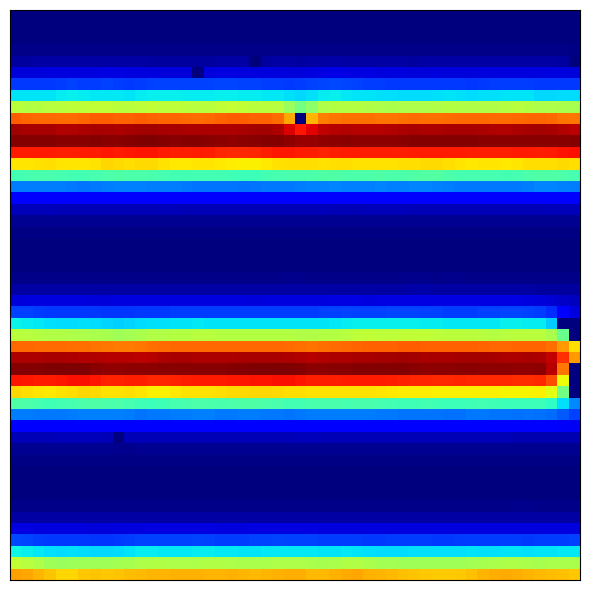

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [8]:
# Reshape band cells
heatmaps_band_x = heatmaps_band_x.reshape(5, -1, M, K)

# Visualize a band cell
config = PlotConfig(
    figsize=(6, 6),
    title=f'Band Cell X - Module {module_idx}, Cell {cell_idx}',
    xlabel='X Position (m)',
    ylabel='Y Position (m)',
    show=True,
    save_path=None
)

plot_firing_field_heatmap(
    heatmaps_band_x[module_idx, cell_idx],
    config=config
)

**Expected patterns**:
- **Parallel stripes** perpendicular to preferred direction
- Different cells have different stripe spacings (phase offsets)
- Multiple modules show different scales of striping

### 4.4 Visualizing Place Cell Fields

Place cells combine grid cell inputs to form localized firing fields:

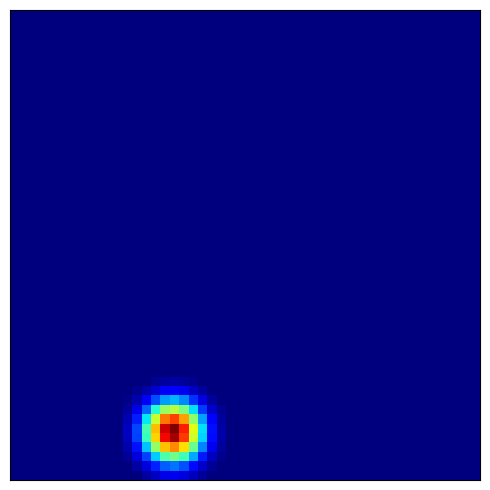

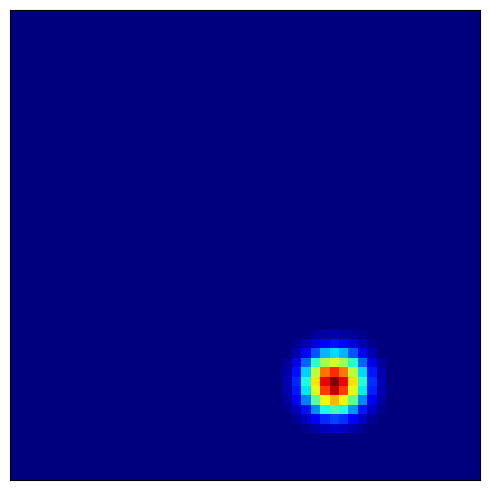

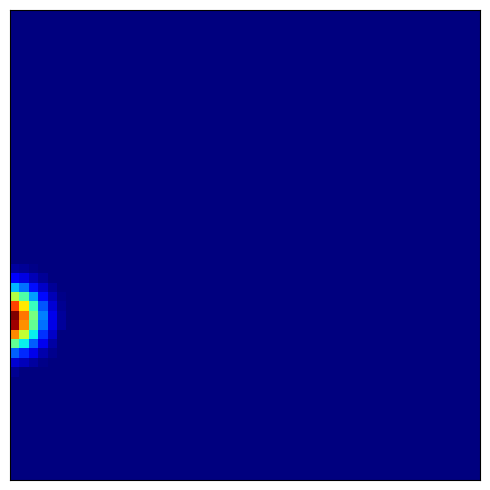

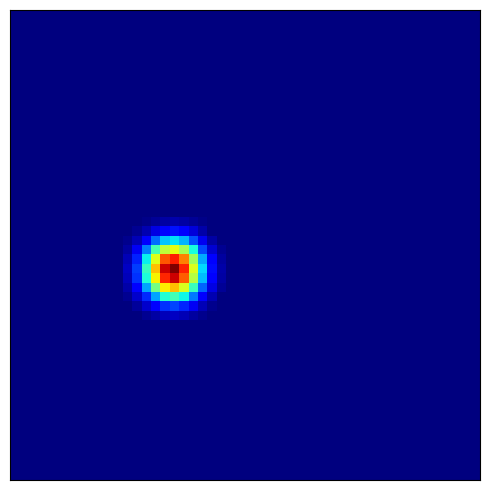

In [9]:
# Visualize several place cells
for place_idx in [100, 200, 300, 400]:
    config = PlotConfig(
        figsize=(5, 5),
        title=f'Place Cell {place_idx}',
        xlabel='X Position (m)',
        ylabel='Y Position (m)',
        show=True,
        save_path=None
    )

    plot_firing_field_heatmap(
        heatmaps_place[place_idx],
        config=config
    )

**Expected patterns**:
- **Localized fields**: Each place cell fires in specific location(s)
- **Multiple fields**: Some cells may have multiple firing locations
- **Coverage**: Different cells tile the entire environment

---

## 5. Next Steps

Congratulations! You've learned how to use hierarchical path integration networks for multi-scale spatial navigation.

### Key Takeaways

1. **Multi-scale representation** - Different modules handle different spatial scales
2. **Initialization is critical** - Strong location input sets consistent starting state
3. **Band cells integrate velocity** - Form 1D stripes along preferred directions
4. **Grid cells form hexagons** - Emerge from band cell interactions
5. **Place cells combine scales** - Provide unique location codes

### When to Use Hierarchical Networks

- **Large environments**: When single-scale grids aren't sufficient
- **Robust navigation**: Multiple scales provide error correction
- **Biological realism**: Matches neural recordings from entorhinal cortex
- **Research applications**: Studying grid cell formation and path integration

### Continue Learning

- **Next**: [Tutorial 6: Theta Sweep System Model](./06_theta_sweep_hd_grid.ipynb) - Learn about theta oscillations in navigation
- **Alternative**: [Tutorial 7: Theta Sweep Place Cell Network](./07_theta_sweep_place_cell.ipynb) - Complex environments with obstacles

### Advanced Topics

- **Module interactions**: How different scales influence each other
- **Error accumulation**: Comparing single vs multi-scale performance
- **Parameter tuning**: Optimizing spacing ranges for different environments
- **Biological validation**: Comparing with experimental data

### Related Models

These hierarchical models are available in the CANNs library:
- `BandCell` - Individual velocity integrator
- `GridCell` - 2D hexagonal attractor
- `HierarchicalPathIntegrationModel` - Single module (3 bands + 1 grid)
- `HierarchicalNetwork` - Multi-module system (used in this tutorial)

For more details, see the [API documentation](../../api_reference.ipynb) or explore the source code in `canns.models.basic.hierarchical_model`.